In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as sc
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
# model metrics
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from prophet import Prophet


In [4]:
df = pd.read_csv('afg_geocoded_imputed.csv')
df

,Semester,World region,Country,Administrative Division,Disease,Serotype/Subtype/Genotype,Animal Category,Species,Measuring units,New outbreaks,Susceptible,Cases,Killed and disposed of,Deaths,Latitude,Longitude,Year
0,Jul-Dec 2009,Americas,United States of America,Indiana,Influenza A virus (Inf. with),-,Domestic,Swine,Animal,1.0,3000.0,1.0,0.0,0.0,40.327013,-86.174693,2009.0
1,Jul-Dec 2009,Americas,United States of America,Virginia,Influenza A virus (Inf. with),-,Domestic,Birds,Animal,1.0,3270.0,1.2,0.0,0.0,37.123224,-78.492772,2009.0
2,Jul-Dec 2009,Asia,China,Beijing,Influenza A virus (Inf. with),-,Domestic,Dogs,Animal,1.0,52.0,2.0,0.0,0.0,40.190632,116.412144,2009.0
3,Jul-Dec 2009,Asia,China,Heilongjiang,Influenza A virus (Inf. with),-,Domestic,Swine,Animal,1.0,60.0,4.0,0.0,0.0,48.000005,127.999992,2009.0
4,Jul-Dec 2009,Asia,Thailand,Saraburi,Influenza A virus (Inf. with),-,Domestic,Swine,Animal,1.0,680.0,34.0,0.0,0.0,14.624056,100.860102,2009.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,Jan-Jun 2025,Europe,Poland,Olszanica,Influenza A viruses of high pathogenicity (Inf...,H5N1,Domestic,Birds,Animal,2.0,44.0,44.0,26.0,18.0,52.860002,23.085551,2025.0
1480,Jan-Jun 2025,Europe,Poland,Piecki,Influenza A viruses of high pathogenicity (Inf...,H5N1,Domestic,Birds,Animal,1.0,18.0,18.0,4.0,14.0,53.749179,21.341220,2025.0
1481,Jan-Jun 2025,Europe,Poland,Puławy,Influenza A viruses of high pathogenicity (Inf...,H5N1,Wild,Mute Swan,Animal,1.0,3.0,1.0,0.2,1.0,51.426260,21.985301,2025.0
1482,Jan-Jun 2025,Europe,Poland,Skępe,Influenza A viruses of high pathogenicity (Inf...,H5N1,Wild,Mute Swan,Animal,1.0,4.8,2.0,0.2,2.0,52.867156,19.346520,2025.0


In [5]:
# find numeric and categorical features
df = pd.get_dummies(df)
y = df['Cases']
X = df.drop('Cases', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object"]).columns


In [6]:
pca = PCA(n_components=10)

x_train = pca.fit_transform(X_train)
x_test = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_

explained_variance_ratio = pca.explained_variance_ratio_
for indx, evr in enumerate(explained_variance_ratio):
    print(f"PC{indx+1}: {evr:.2f}")

PC1: 0.98
PC2: 0.02
PC3: 0.01
PC4: 0.00
PC5: 0.00
PC6: 0.00
PC7: 0.00
PC8: 0.00
PC9: 0.00
PC10: 0.00


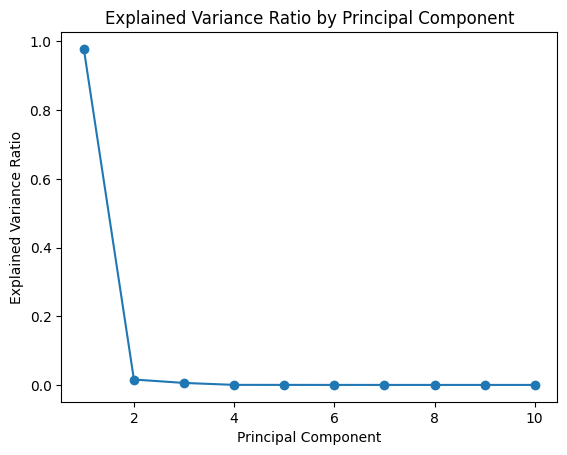

In [7]:
fig, ax = plt.subplots()
# set x and y values
x = np.arange(1, len(explained_variance_ratio) + 1)
y = explained_variance_ratio
# plot
ax.plot(x, y, marker='o')
# set label and title
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Explained Variance Ratio by Principal Component')
plt.show()

In [8]:
feature_names = X_train.columns
# Accessing the component weights
component_weights = pca.components_
#print("Component Weights:\n", component_weights)
# Create a mapping between component weights and feature names
feature_weights_mapping = {}
for i, component in enumerate(component_weights):
    component_feature_weights = zip(feature_names, component)
    feature_weights_mapping[f"Component {i+1}"] = sorted(
      component_feature_weights, key=lambda x: abs(x[1]), reverse=True)

# Accessing feature names contributing to Component 1
print("Feature names contributing to Component 1:")
for feature, weight in feature_weights_mapping["Component 1"]:
    print(f"{feature}: {weight}")

# Accessing feature names contributing to Component 2
print("Feature names contributing to Component 2:")
for feature, weight in feature_weights_mapping["Component 2"]:
    print(f"{feature}: {weight}")

Feature names contributing to Component 1:
Susceptible: 0.7933291515928066
Killed and disposed of: 0.5803172722281345
Deaths: 0.18314206216744056
New outbreaks: 0.012795192889298646
Longitude: -0.012376157253467187
Latitude: 0.0016635934555223936
Administrative Division_United States of America: 0.00011705741722269665
Country_United States of America: 9.938351091539042e-05
World region_Americas: 8.871044847300615e-05
Year: 6.982041899383723e-05
World region_Europe: -5.8514979967383136e-05
Country_Poland: -5.8514979967383136e-05
Serotype/Subtype/Genotype_H5N1: 3.3660935460053617e-05
Semester_Jul-Dec 2022: 3.353383540254668e-05
World region_Africa: -2.5766330881251963e-05
Country_South Africa: -2.5766330881251963e-05
Species_unknown: -2.469786596620702e-05
Measuring units_-: -2.469786596620702e-05
Measuring units_Animal: 2.4697865966207017e-05
Serotype/Subtype/Genotype_H5N8: -2.297252823483619e-05
Semester_Jan-Jun 2022: 2.1468477440553877e-05
Animal Category_Wild: 2.0552250860822013e-05


In [9]:
df.corr()

,New outbreaks,Susceptible,Cases,Killed and disposed of,Deaths,Latitude,Longitude,Year,Semester_Jan-Jun 2017,Semester_Jan-Jun 2018,...,Species_Whooper Swan,Species_Wild turkey,Species_Wildlife (species unspecified),Species_Willet,Species_Wood Duck,Species_Wood Stork,Species_Yellow-billed Duck,Species_unknown,Measuring units_-,Measuring units_Animal
New outbreaks,1.000000,0.878099,-0.022741,0.867574,0.694555,0.152281,-0.625677,0.025426,-0.088040,-0.066156,...,-0.019955,0.054579,-0.062679,0.036767,0.064272,0.064089,-0.019680,-0.240265,-0.240265,0.240265
Susceptible,0.878099,1.000000,0.199140,0.941591,0.868101,0.158848,-0.666604,0.093689,-0.102586,-0.111470,...,-0.025503,0.054409,-0.062124,0.040641,0.066618,0.057494,-0.021007,-0.239002,-0.239002,0.239002
Cases,-0.022741,0.199140,1.000000,-0.013957,0.628895,-0.062170,0.081244,-0.042023,0.012424,0.025082,...,-0.002914,-0.003817,0.062795,-0.002060,-0.000299,-0.002914,-0.002914,0.010923,0.010923,-0.010923
Killed and disposed of,0.867574,0.941591,-0.013957,1.000000,0.754601,0.231496,-0.728261,0.157176,-0.098979,-0.115324,...,-0.024616,0.050070,-0.069132,0.039145,0.072924,0.055379,-0.024608,-0.269241,-0.269241,0.269241
Deaths,0.694555,0.868101,0.628895,0.754601,1.000000,0.138772,-0.510594,0.075427,-0.072715,-0.065774,...,-0.020868,0.040783,-0.009683,0.032078,0.052851,0.045380,-0.020888,-0.197820,-0.197820,0.197820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Species_Wood Stork,0.064089,0.057494,-0.002914,0.055379,0.045380,0.012843,-0.040437,-0.003050,-0.005955,-0.006346,...,-0.001350,-0.001910,-0.003835,-0.000954,-0.002341,1.000000,-0.001350,-0.016455,-0.016455,0.016455
Species_Yellow-billed Duck,-0.019680,-0.021007,-0.002914,-0.024608,-0.020888,-0.067749,0.032718,-0.055680,-0.005955,-0.006346,...,-0.001350,-0.001910,-0.003835,-0.000954,-0.002341,-0.001350,1.000000,-0.016455,-0.016455,0.016455
Species_unknown,-0.240265,-0.239002,0.010923,-0.269241,-0.197820,0.031026,0.357666,-0.074280,0.076036,-0.012771,...,-0.016455,-0.023287,-0.046764,-0.011632,-0.028540,-0.016455,-0.016455,1.000000,1.000000,-1.000000
Measuring units_-,-0.240265,-0.239002,0.010923,-0.269241,-0.197820,0.031026,0.357666,-0.074280,0.076036,-0.012771,...,-0.016455,-0.023287,-0.046764,-0.011632,-0.028540,-0.016455,-0.016455,1.000000,1.000000,-1.000000


Time Series

In [10]:
import warnings
warnings.filterwarnings('ignore')


semester_cols = [col for col in df.columns if col.startswith('Semester_')]

def semester_col_to_date(col_name):
    sem, year = col_name.replace('Semester_', '').split()
    if sem == 'Jan-Jun':
        return pd.to_datetime(f'{year}-04-01')
    else:
        return pd.to_datetime(f'{year}-10-01')

time_data = []
for sem_col in semester_cols:
    date = semester_col_to_date(sem_col)
    cases = df.loc[df[sem_col] == 1, 'Cases'].sum()
    time_data.append({'Date': date, 'Cases': cases})

time_series = (pd.DataFrame(time_data)
               .sort_values('Date')
               .set_index('Date')['Cases'])

start_date = time_series.index.min()
end_date = time_series.index.max()
full_range = pd.date_range(start=start_date, end=end_date, freq='6MS')
time_series = time_series.reindex(full_range).fillna(0)

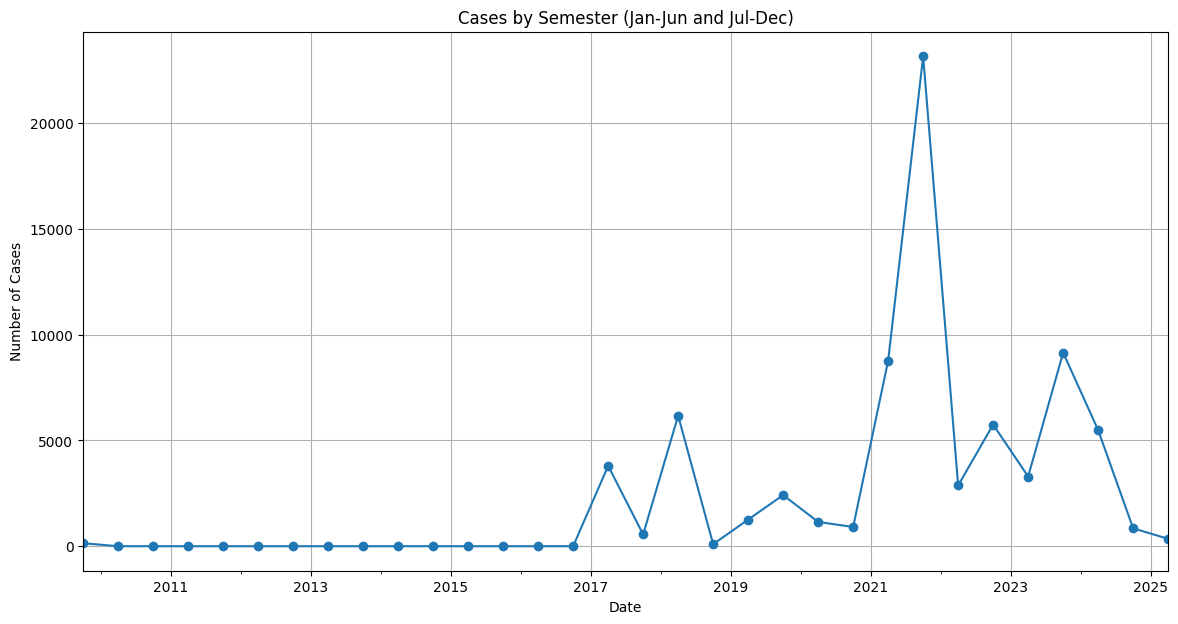

In [11]:
# Plot
plt.figure(figsize=(14, 7))
time_series.plot(title='Cases by Semester (Jan-Jun and Jul-Dec)', marker='o', linestyle='-')
plt.ylabel('Number of Cases')
plt.xlabel('Date')
plt.grid(True)
plt.show()

In [12]:
result = adfuller(time_series)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: 0.5404743221383377
p-value: 0.9860527261932958
Critical Values: {'1%': np.float64(-3.7883858816542486), '5%': np.float64(-3.013097747543462), '10%': np.float64(-2.6463967573696143)}


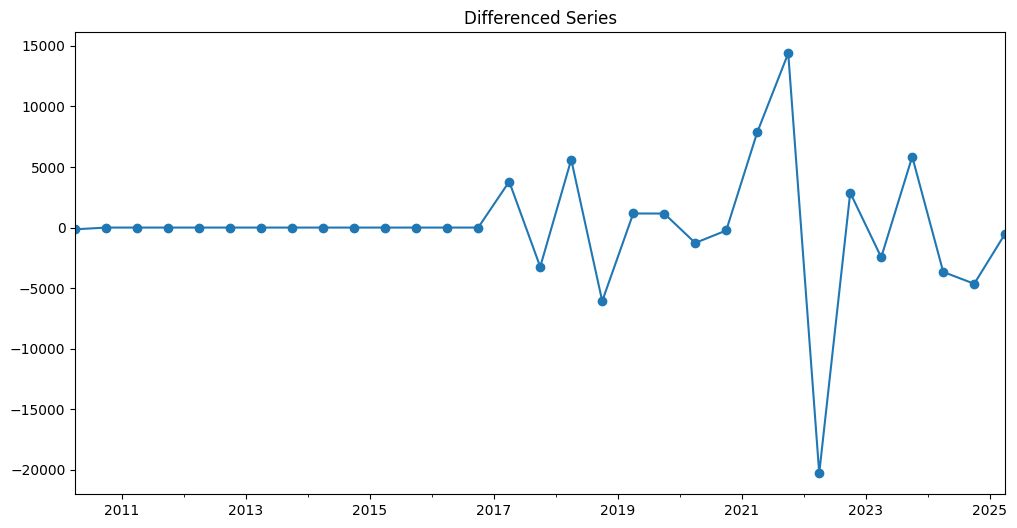

In [13]:
# If p-value > 0.05
if result[1] > 0.05:
    time_series_diff = time_series.diff().dropna()
    plt.figure(figsize=(12, 6))
    time_series_diff.plot(title='Differenced Series', marker='o')
    plt.show()

In [14]:
# Split into train and test
train = time_series[:-4]
test = time_series[-4:]

# Fit model
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 2)

model = SARIMAX(train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Cases   No. Observations:                   28
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 2)   Log Likelihood                -213.628
Date:                           Wed, 23 Apr 2025   AIC                            437.255
Time:                                   22:57:23   BIC                            442.478
Sample:                               10-01-2009   HQIC                           438.389
                                    - 04-01-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1675      0.986      0.170      0.865      -1.766       2.101
ma.L1         -0.9180      0.889     -1.032

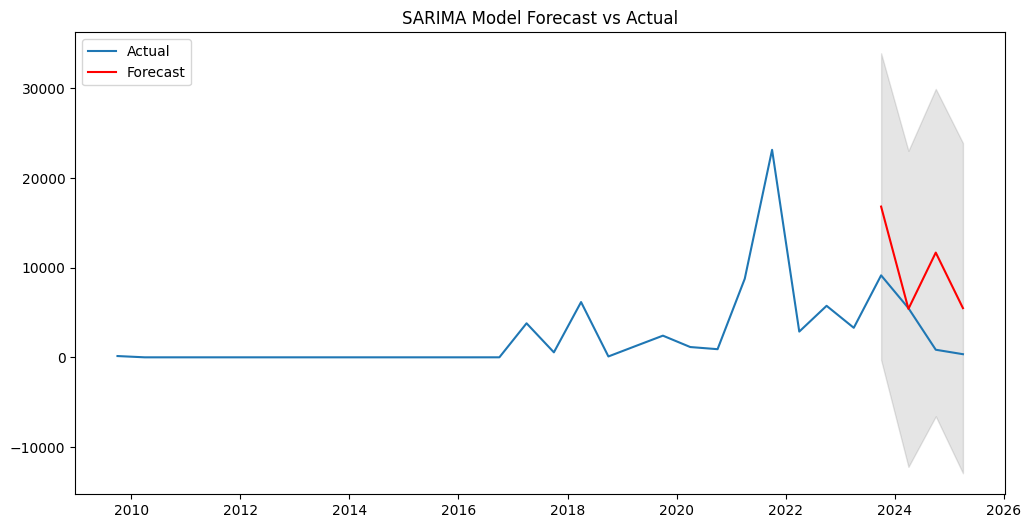

RMSE: 7119.177369276158


In [15]:
# Predictions
pred = results.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
pred_ci = pred.conf_int()

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Actual')
plt.plot(pred.predicted_mean, label='Forecast', color='red')
plt.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.1)
plt.title('SARIMA Model Forecast vs Actual')
plt.legend()
plt.show()

# RMSE
rmse = np.sqrt(mean_squared_error(test, pred.predicted_mean))
print(f'RMSE: {rmse}')

Random Forrest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    # ("scaler", StandardScaler()),  # not needed for trees
    ("model", RandomForestRegressor(random_state=42))
])
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5],
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="r2")
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("RandomForest Best R²:", grid_search.best_score_)
cv_results = cross_validate(best_model, X, y, cv=5, scoring='r2', return_train_score=True)
print(cv_results['test_score'])

In [ ]:
print("X shape:", X.shape)
print("y shape:", y.shape)

# 1. Basic shape check
print("df shape:", df.shape)

# 2. Create X and y
y = df['Cases']
X = df.drop('Cases', axis=1)

# 3. Print X and y shape
print("X shape:", X.shape)
print("y shape:", y.shape)

# 4. Check if there are any NaNs
print("NaNs in y:", y.isna().sum())
print("NaNs in X:", X.isna().sum().sum())  # total NaNs in X

# 5. Confirm alignment
print("X and y aligned?", len(X) == len(y))


In [ ]:
import folium
from folium.plugins import MarkerCluster

y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

df_test = X_test.copy()
df_test['actual'] = y_test
df_test['predicted'] = y_pred

# --- Create a base map centered on the mean location ---
map_center = [df_test['Latitude'].mean(), df_test['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=10)

# --- Create a marker cluster to avoid overlap ---
marker_cluster = MarkerCluster().add_to(m)

# --- Add markers with predicted values ---
for _, row in df_test.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        fill=True,
        fill_color='blue',
        color='black',
        fill_opacity=0.7,
        popup=f"Predicted: {row['predicted']:.2f}<br>Actual: {row['actual']:.2f}"
    ).add_to(marker_cluster)

# --- Display the map ---
m


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# --- Optional: Spatial Plot of Predictions ---
df_test = X_test.copy()
df_test['actual'] = y_test
df_test['predicted'] = y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_test, x='lon', y='lat', hue='predicted', palette='viridis', s=60)
plt.title("Predicted Spatial Values")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Prediction")
plt.show()



Hybrid mode

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import root_mean_squared_error, r2_score

# ---- Step 1: Fit SARIMAX on training target ----
sarimax_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_result = sarimax_model.fit(disp=False)

# ---- Step 2: Predict SARIMAX on train & test ----
sarimax_pred_train = sarimax_result.predict(start=y_train.index[0], end=y_train.index[-1])
n_steps = len(y_test)
sarimax_forecast = sarimax_result.get_forecast(steps=n_steps)
sarimax_pred_test = sarimax_forecast.predicted_mean
sarimax_pred_test.index = y_test.index  # Align index with test


# ---- Step 3: Compute residuals ----
sarimax_pred_train = sarimax_pred_train.reindex(y_train.index)
residuals_train = (y_train - sarimax_pred_train).dropna()

# ---- Step 4: Align X_train with residuals ----
X_train_aligned = X_train.loc[residuals_train.index]

# ---- Step 5: Fit Random Forest on residuals ----
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_aligned, residuals_train)

# ---- Step 6: Predict residuals on test data ----
residuals_pred_rf = rf_model.predict(X_test)

# ---- Step 7: Combine predictions ----
sarimax_pred_test = sarimax_pred_test.reindex(y_test.index)

# Drop NaNs from SARIMAX test predictions and align everything
valid_idx = sarimax_pred_test.dropna().index
sarimax_pred_test_valid = sarimax_pred_test.loc[valid_idx]
# Convert residuals to Series with matching index
residuals_pred_rf_series = pd.Series(residuals_pred_rf, index=X_test.index)

# Align predictions and drop NaNs from any
df_eval = pd.concat([
    y_test.rename("actual"),
    sarimax_pred_test.rename("sarimax"),
    residuals_pred_rf_series.rename("rf_resid")
], axis=1)

# Drop rows with any NaNs
df_eval = df_eval.dropna()

# Reconstruct hybrid prediction
hybrid_pred_test = df_eval["sarimax"] + df_eval["rf_resid"]

# ---- Step 8: Evaluate ----
rmse = root_mean_squared_error(df_eval["actual"], hybrid_pred_test)
r2 = r2_score(df_eval["actual"], hybrid_pred_test)

print("✅ Hybrid Model RMSE:", round(rmse, 2))
print("✅ Hybrid Model R²:", round(r2, 4))


In [ ]:

data = pd.read_csv('afg_geocoded_imputed.csv')

# Convert Semester to datetime
def semester_to_date(semester_str):
    parts = semester_str.split()
    if parts[0] == 'Jan-Jun':
        return pd.to_datetime(f"{parts[1]}-01-01")
    elif parts[0] == 'Jul-Dec':
        return pd.to_datetime(f"{parts[1]}-07-01")
    return pd.NaT

# Aggregate data
data_ts = data.groupby("Semester", as_index=False)["Cases"].sum()
data_ts['ds'] = data_ts['Semester'].apply(semester_to_date)
data_ts = data_ts.dropna(subset=['ds'])
data_ts = data_ts.rename(columns={'Cases': 'y'})

# Fit model
model = Prophet()
model.fit(data_ts[['ds', 'y']])

# Forecast
future = model.make_future_dataframe(periods=4, freq='6MS')
forecast = model.predict(future)

# Plot
model.plot(forecast)
plt.title('Prophet Forecast of Total Cases')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.grid(True)
plt.tight_layout()
plt.show()